
# High-Level Architecture — Report

Interactive visuals for the **High_Level_Architecture** block using CSV files located at:
`reports/custom-queries-csv/High_Level_Architecture/`

**What's Included**
- **Architectural Layer Violations**: Controller → Repository (bypassing Service) overview.
- **Cyclomatic Complexity**: top methods, distribution, and a quick box view.
- **Deepest Inheritance**: classes with the highest inheritance depth.
- **Excessive Dependencies**: classes with unusually high dependency counts.
- **General Count Overview**: quick totals (packages, classes, artifacts, etc.).
- **God Classes**: classes with a very high number of methods.
- **Highest Number of Methods**: top classes by method count.
- **Inheritance Between Classes**: lightweight relationship view (top pairs table + bar of top parents).
- **Package Structure**: package hierarchy treemap (split by dots).

> The notebook is resilient: if a CSV is missing, an info message is printed and the rest continues.


In [1]:

# Setup and helpers (English comments)
import os, glob
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display

pd.set_option('future.no_silent_downcasting', True)

def resolve_reports_dir():
    """Resolve base 'reports' directory with env var fallback and upward search."""
    env = os.environ.get("REPORTS_DIRECTORY")
    if env:
        p = Path(env).expanduser().resolve()
        if p.exists():
            return str(p)
    cwd = Path.cwd()
    for i in range(0, 8):
        base = cwd if i == 0 else cwd.parents[i-1]
        cand = base / "reports"
        if cand.exists():
            return str(cand.resolve())
    return str((Path.cwd() / "reports").resolve())

REPORTS_DIR = resolve_reports_dir()
HLA_DIR = os.path.join(REPORTS_DIR, "custom-queries-csv", "High_Level_Architecture")
print("Reports:", HLA_DIR)

NA_LITS = ["", " ", "NA", "N/A", "n/a", "NaN", "NULL", "Null", "null", "None", "none", "-", "--"]

def read_csv_safe(p):
    """Read CSV gracefully with tolerant NA handling."""
    if not os.path.exists(p):
        print(f"[info] Missing CSV: {p}")
        return pd.DataFrame()
    try:
        df = pd.read_csv(p, na_values=NA_LITS, keep_default_na=True)
        df.columns = [str(c).strip() for c in df.columns]
        return df.dropna(how="all")
    except Exception as e:
        print(f"[warn] Failed to read {p}: {e}")
        return pd.DataFrame()

def find_col(df, *cands, default=None, contains=None):
    """Return a column name by exact candidates or substring (case-insensitive)."""
    if df is None or df.empty:
        return default
    low = {c.lower(): c for c in df.columns}
    for c in cands:
        if c and c.lower() in low:
            return low[c.lower()]
    if contains:
        for k, orig in low.items():
            if contains.lower() in k:
                return orig
    return default

def show_empty(msg):
    fig = go.Figure()
    fig.update_layout(
        title=msg,
        annotations=[dict(text="No data", x=0.5, y=0.5, showarrow=False)]
    )
    fig.show()

MAX_SHOW = 20  # limit for heads / tops


Reports: /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/custom-queries-csv/High_Level_Architecture


## 1) Architectural Layer Violation

In [12]:
# Architectural Layer Violation — text-only when no data
path = os.path.join(HLA_DIR, "Architectural_Layer_Violation.csv")
df_lv = read_csv_safe(path)

c_controller = find_col(df_lv, "Controller", contains="controller")
c_repository = find_col(df_lv, "Repository", contains="repositor")
c_violation  = find_col(df_lv, "Violation", contains="violation", default="Violation")

# Guard clause: no data or missing columns -> text message only
if df_lv.empty or not (c_controller and c_repository):
    print("[info] No data found for Architectural Layer Violations (missing CSV or required columns).")
else:
    # Tiny preview only (reduce noise)
    display(df_lv[[c_controller, c_repository]].head(5))

    # Counts
    cnt_ctrl = df_lv[c_controller].value_counts().rename_axis("controller").reset_index(name="violations")
    cnt_repo = df_lv[c_repository].value_counts().rename_axis("repository").reset_index(name="violations")

    if cnt_ctrl.empty and cnt_repo.empty:
        print("[info] Architectural Layer Violations: CSV loaded but no rows to visualize.")
    else:
        # Donut for controllers (top 15)
        if not cnt_ctrl.empty:
            top_c = cnt_ctrl.head(15)
            fig = px.pie(top_c, values="violations", names="controller",
                         title="Controllers with most layer violations (Top 15)", hole=0.45)
            fig.update_layout(height=620, width=950)
            fig.show()
        else:
            print("[info] No controller-side violations to show.")

        # Treemap for repositories (top 25)
        if not cnt_repo.empty:
            top_r = cnt_repo.head(25)
            fig = px.treemap(top_r, path=["repository"], values="violations",
                             title="Repositories most frequently bypassed (Treemap)")
            fig.update_layout(height=650, width=900)
            fig.show()
        else:
            print("[info] No repository-side violations to show.")

        # Sankey: Controller -> Repository (sampled)
        sample = df_lv[[c_controller, c_repository]].dropna().head(180)
        if sample.empty:
            print("[info] Not enough pairs for Sankey (Controller → Repository).")
        else:
            try:
                labels = pd.Index(sorted(set(sample[c_controller]) | set(sample[c_repository]))).tolist()
                idx = {name: i for i, name in enumerate(labels)}
                sources = sample[c_controller].map(idx).tolist()
                targets = sample[c_repository].map(idx).tolist()
                values  = [1]*len(sample)
                fig = go.Figure(data=[go.Sankey(
                    node=dict(label=labels, pad=10, thickness=12),
                    link=dict(source=sources, target=targets, value=values)
                )])
                fig.update_layout(title_text="Controller → Repository (sampled)", height=600, width=1100)
                fig.show()
            except Exception as e:
                print(f"[info] Sankey skipped: {e}")


[info] No data found for Architectural Layer Violations (missing CSV or required columns).


## 2) Cyclomatic Complexity (> 10)

In [3]:

path = os.path.join(HLA_DIR, "Cyclomatic_Complexity.csv")
df_cc = read_csv_safe(path)

c_class  = find_col(df_cc, "Class", contains="class")
c_method = find_col(df_cc, "Method", contains="method")
c_cc     = find_col(df_cc, "cyclomaticComplexity", contains="complex", default="cyclomaticComplexity")

if df_cc.empty or not (c_class and c_method and c_cc):
    show_empty("Cyclomatic Complexity")
else:
    df_cc[c_cc] = pd.to_numeric(df_cc[c_cc], errors="coerce")
    df_cc = df_cc.dropna(subset=[c_cc])

    # Minimal preview
    display(df_cc[[c_class, c_method, c_cc]].head(5))

    # Violin (with outliers)
    fig = px.violin(df_cc, y=c_cc, box=True, points="outliers", title="Cyclomatic Complexity — Violin")
    fig.update_layout(height=450, width=600)
    fig.show()

    # Scatter top N
    top = df_cc.sort_values(c_cc, ascending=False).head(120)
    fig = px.scatter(top, x=c_method, y=c_cc, hover_data=[c_class],
                     title="Top methods by cyclomatic complexity (scatter)")
    fig.update_layout(xaxis_tickangle=-35, height=550, width=1100)
    fig.show()


,Class,Method,cyclomaticComplexity
0,net.sourceforge.htmlunit.cyberneko.HTMLEntitie...,parse5,3491
1,net.sourceforge.htmlunit.cyberneko.HTMLEntitie...,parse1,3456
2,net.sourceforge.htmlunit.cyberneko.HTMLEntitie...,parse4,3452
3,net.sourceforge.htmlunit.cyberneko.HTMLEntitie...,parse6,3448
4,net.sourceforge.htmlunit.cyberneko.HTMLEntitie...,parse7,3436


## 3) Deepest Inheritance

,class.fqn,Depth
0,com.github.javaparser.ast.validator.Java12Vali...,14
1,com.github.javaparser.ast.validator.Java11Vali...,13
2,com.github.javaparser.ast.validator.Java10Vali...,12
3,com.github.javaparser.ast.validator.Java9Valid...,11
4,org.hibernate.dialect.PostgreSQL10Dialect,10


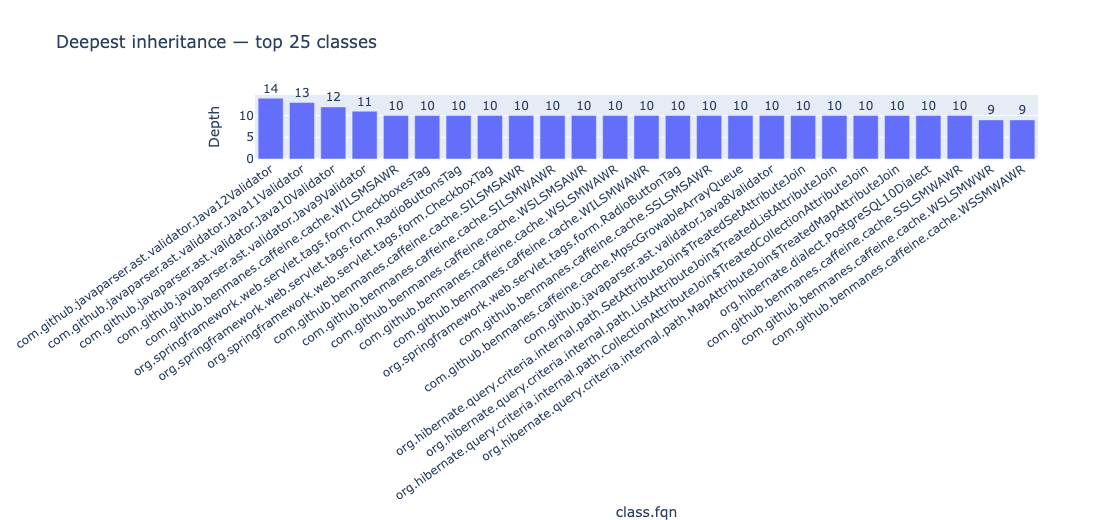

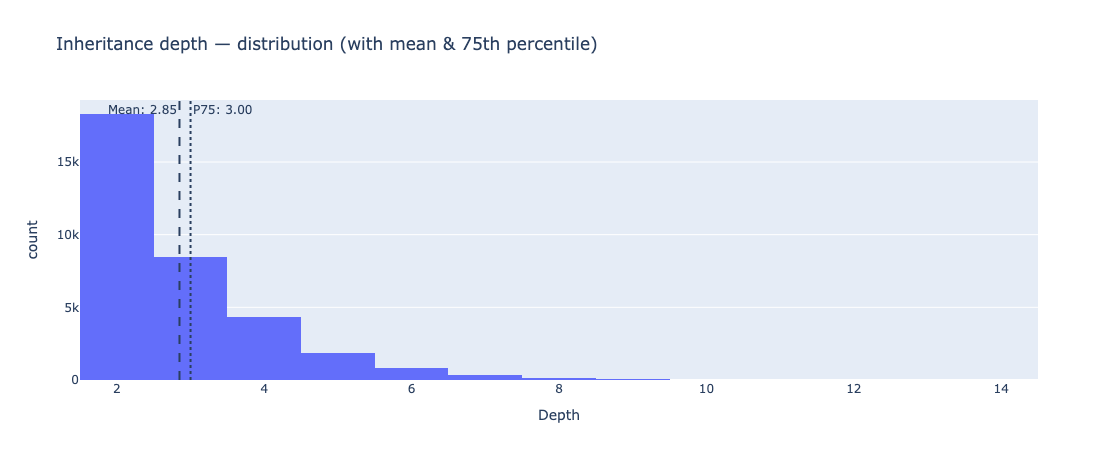

In [4]:
# Deepest Inheritance — simple & clear version
path = os.path.join(HLA_DIR, "Deepest_Inheritance.csv")
df_di = read_csv_safe(path)

c_class = find_col(df_di, "class.fqn", "Class", contains="class")
c_depth = find_col(df_di, "Depth", contains="depth", default="Depth")

if df_di.empty or not (c_class and c_depth):
    show_empty("Deepest Inheritance")
else:
    # Ensure numeric depth
    df_di[c_depth] = pd.to_numeric(df_di[c_depth], errors="coerce").fillna(0)

    # Tiny preview (only 5 rows)
    display(df_di[[c_class, c_depth]].head(5))

    # ---- A) Top classes by depth (one clear bar chart) ----
    TOP_N = 25
    top = df_di.sort_values(c_depth, ascending=False).head(TOP_N)
    fig = px.bar(
        top, x=c_class, y=c_depth, text=c_depth,
        title=f"Deepest inheritance — top {TOP_N} classes"
    )
    fig.update_traces(textposition="outside", cliponaxis=False)
    fig.update_layout(xaxis_tickangle=-35, height=520, width=1100)
    fig.show()

    # ---- B) Depth distribution (histogram + guide lines) ----
    mean_val = float(df_di[c_depth].mean())
    p75_val  = float(df_di[c_depth].quantile(0.75))

    fig = px.histogram(
        df_di, x=c_depth, nbins=20,
        title="Inheritance depth — distribution (with mean & 75th percentile)"
    )
    # Guide lines
    fig.add_vline(x=mean_val, line_dash="dash", annotation_text=f"Mean: {mean_val:.2f}", annotation_position="top left")
    fig.add_vline(x=p75_val, line_dash="dot",  annotation_text=f"P75: {p75_val:.2f}",  annotation_position="top right")

    fig.update_layout(height=460, width=900)
    fig.show()


## 4) Excessive Dependencies (> 15)

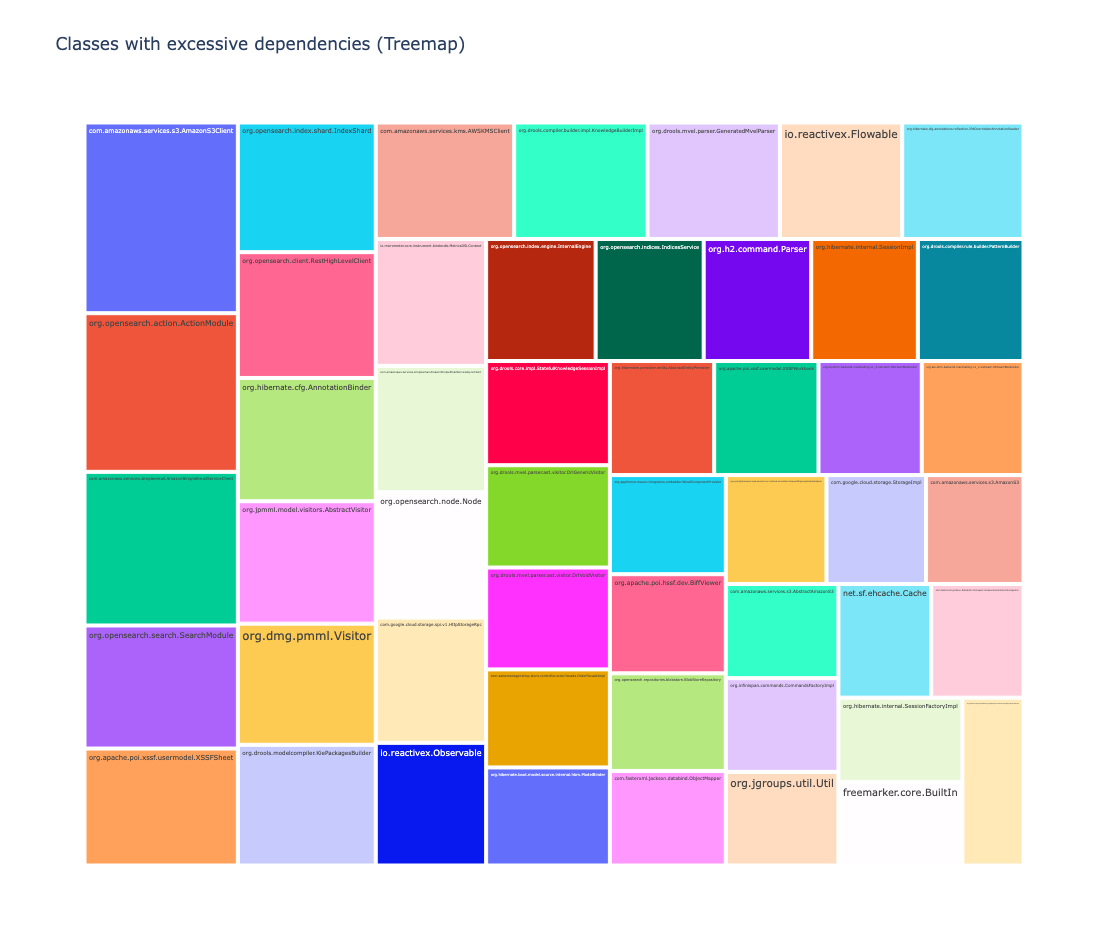

In [11]:

path = os.path.join(HLA_DIR, "Excessive_Dependencies.csv")
df_ed = read_csv_safe(path)

c_fqn = find_col(df_ed, "classFqn", contains="fqn", default="classFqn")
c_dep = find_col(df_ed, "dependencies", contains="depend", default="dependencies")

if df_ed.empty or not (c_fqn and c_dep):
    show_empty("Excessive Dependencies")
else:
    df_ed[c_dep] = pd.to_numeric(df_ed[c_dep], errors="coerce").fillna(0)

    # Treemap for top classes
    top = df_ed.sort_values(c_dep, ascending=False).head(50)
    fig = px.treemap(top, path=[c_fqn], values=c_dep, title="Classes with excessive dependencies (Treemap)")
    fig.update_layout(height=950, width=950)
    fig.show()



## 5) General Count Overview

In [6]:

path = os.path.join(HLA_DIR, "General_Count_Overview.csv")
df_go = read_csv_safe(path)

c_info  = find_col(df_go, "Info", contains="info", default="Info")
c_count = find_col(df_go, "Count", contains="count", default="Count")

if df_go.empty or not (c_info and c_count):
    show_empty("General Count Overview")
else:
    df_go[c_count] = pd.to_numeric(df_go[c_count], errors="coerce").fillna(0)

    # Donut proportions
    fig = px.pie(df_go, values=c_count, names=c_info, title="General counts — proportions", hole=0.45)
    fig.update_layout(height=520, width=720)
    fig.show()


## 6) God Classes (> 20 methods)

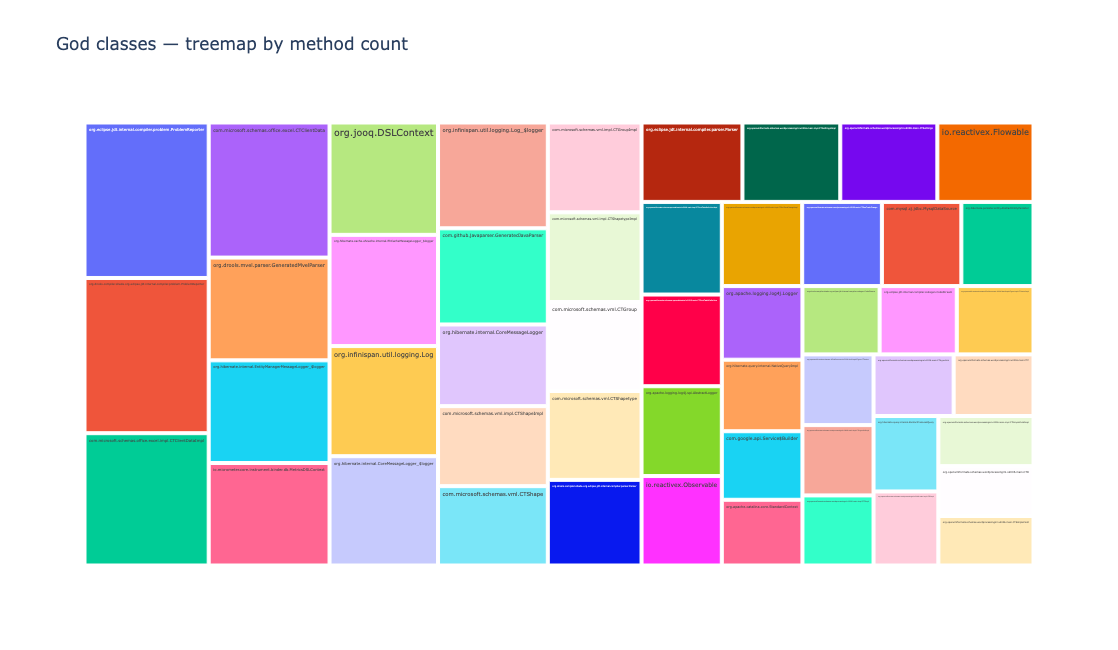

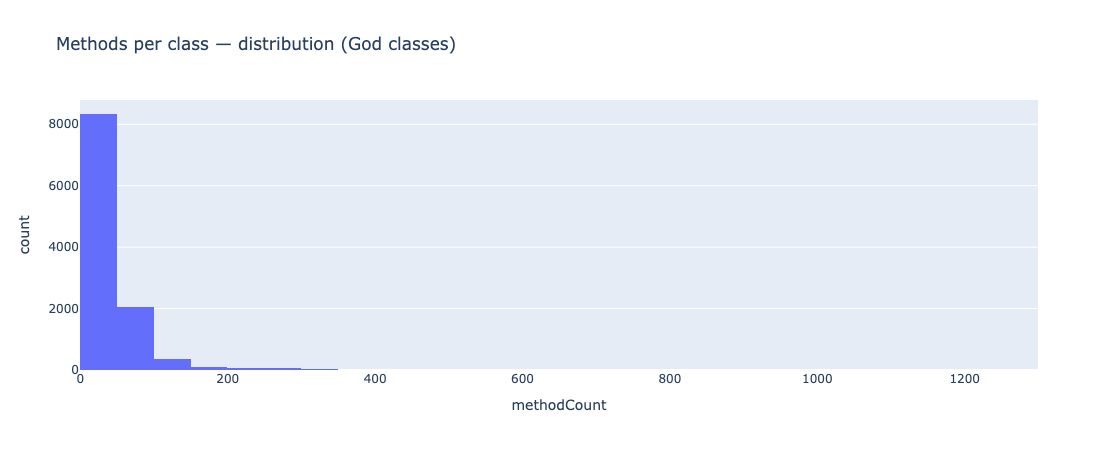

In [7]:

path = os.path.join(HLA_DIR, "God_Classes.csv")
df_gc = read_csv_safe(path)

c_fqn = find_col(df_gc, "fqn_god_class", contains="fqn", default="fqn_god_class")
c_cnt = find_col(df_gc, "methodCount", contains="method", default="methodCount")

if df_gc.empty or not (c_fqn and c_cnt):
    show_empty("God Classes")
else:
    df_gc[c_cnt] = pd.to_numeric(df_gc[c_cnt], errors="coerce").fillna(0)

    # Treemap
    top = df_gc.sort_values(c_cnt, ascending=False).head(50)
    fig = px.treemap(top, path=[c_fqn], values=c_cnt, title="God classes — treemap by method count")
    fig.update_layout(height=650, width=900)
    fig.show()

    # Histogram
    fig = px.histogram(df_gc, x=c_cnt, nbins=30, title="Methods per class — distribution (God classes)")
    fig.update_layout(height=450, width=850)
    fig.show()


## 7) Highest Number of Methods per Class (> 15)

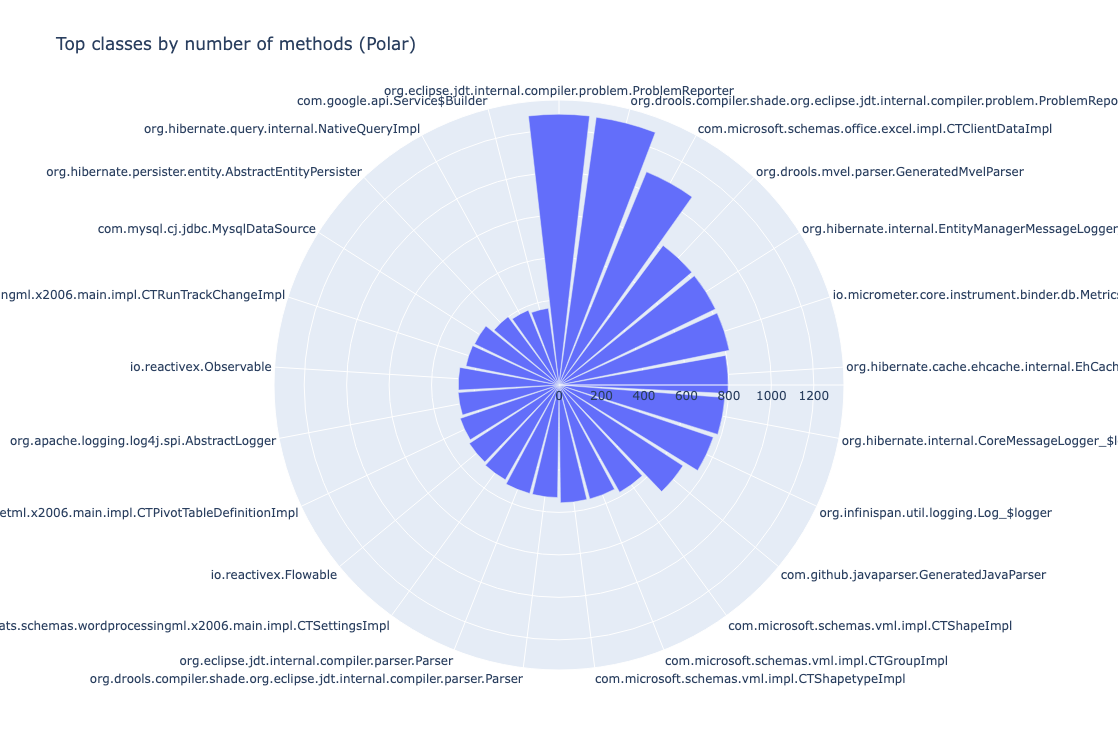

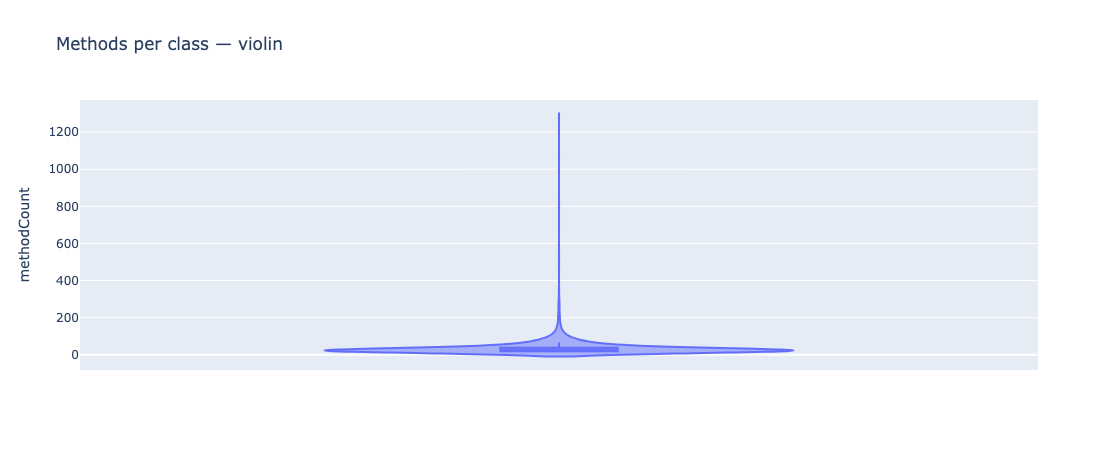

In [8]:

path = os.path.join(HLA_DIR, "Highest_Number_Methods_Class.csv")
df_hm = read_csv_safe(path)

c_class = find_col(df_hm, "class.fqn", "Class", contains="class")
c_cnt   = find_col(df_hm, "methodCount", contains="method", default="methodCount")

if df_hm.empty or not (c_class and c_cnt):
    show_empty("Highest Number of Methods per Class")
else:
    df_hm[c_cnt] = pd.to_numeric(df_hm[c_cnt], errors="coerce").fillna(0)
    top = df_hm.sort_values(c_cnt, ascending=False).head(25)

    # Polar bar chart
    fig = px.bar_polar(top, r=c_cnt, theta=c_class, title="Top classes by number of methods (Polar)")
    fig.update_layout(height=750, width=900)
    fig.show()

    # Violin across all
    fig = px.violin(df_hm, y=c_cnt, box=True, points=False, title="Methods per class — violin")
    fig.update_layout(height=450, width=600)
    fig.show()


## 8) Inheritance Between Classes

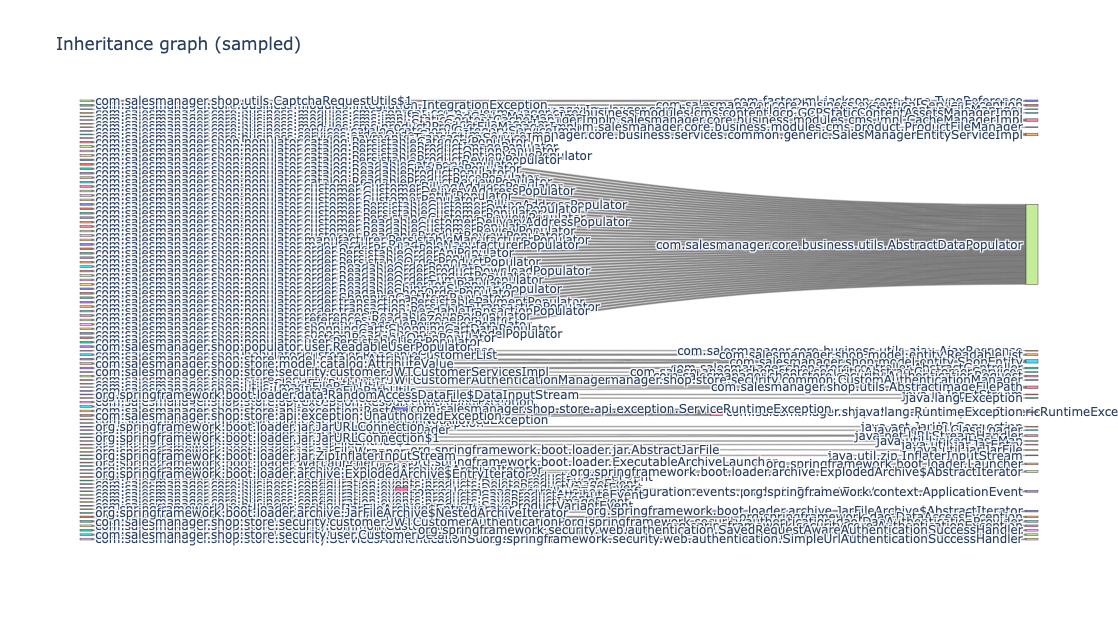

In [9]:

path = os.path.join(HLA_DIR, "Inheritance_Between_Classes.csv")
df_ibc = read_csv_safe(path)

c_c1 = find_col(df_ibc, "class_1_fqn", contains="class_1")
c_c2 = find_col(df_ibc, "class_2_fqn", contains="class_2")

if df_ibc.empty or not (c_c1 and c_c2):
    show_empty("Inheritance Between Classes")
else:
    try:
        sample = df_ibc[[c_c1, c_c2]].dropna().head(180)
        labels = pd.Index(sorted(set(sample[c_c1]) | set(sample[c_c2]))).tolist()
        idx = {name: i for i, name in enumerate(labels)}
        sources = sample[c_c1].map(idx).tolist()
        targets = sample[c_c2].map(idx).tolist()
        values  = [1]*len(sample)

        fig = go.Figure(data=[go.Sankey(
            node=dict(label=labels, pad=10, thickness=12),
            link=dict(source=sources, target=targets, value=values)
        )])
        fig.update_layout(title_text="Inheritance graph (sampled)", height=620, width=1100)
        fig.show()
    except Exception as e:
        print('[info] Sankey skipped:', e)


## 9) Package Structure (Treemap + Icicle)

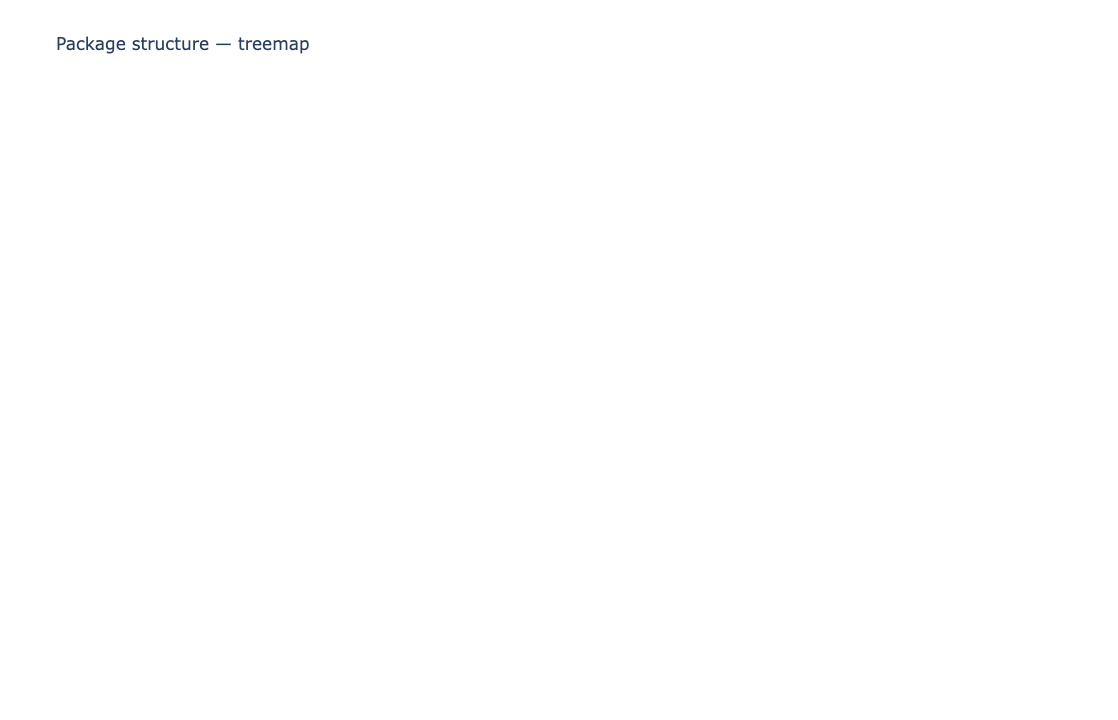

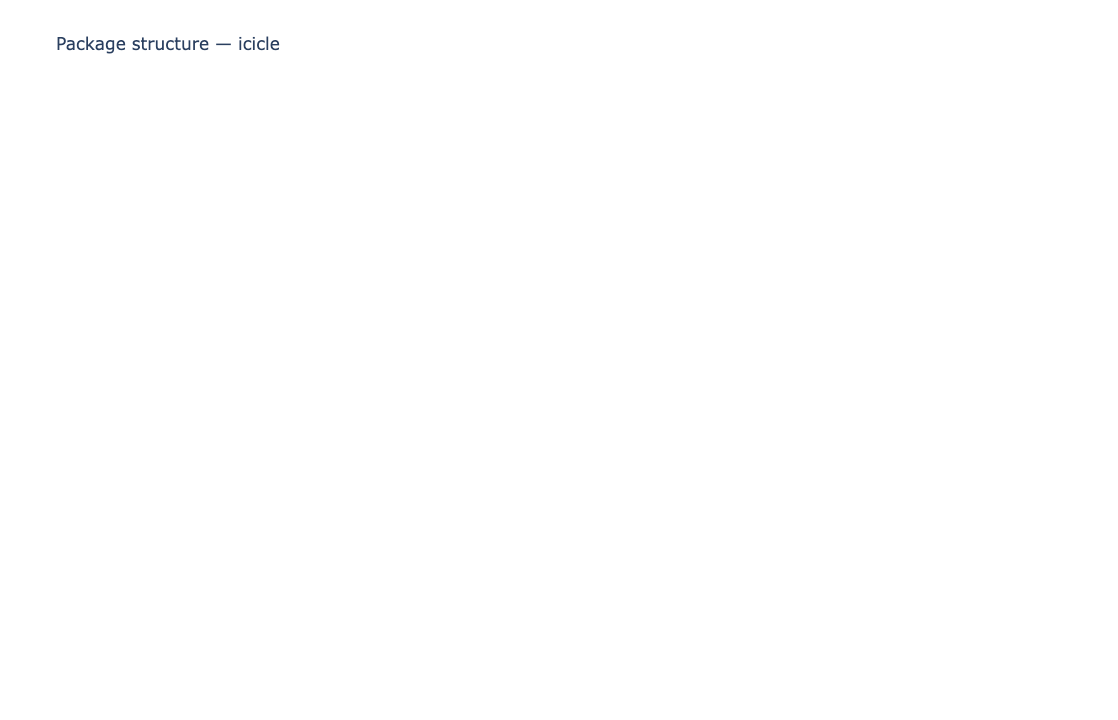

In [10]:

path = os.path.join(HLA_DIR, "Package_Structure.csv")
df_pkg = read_csv_safe(path)

c_pkg = find_col(df_pkg, "packageFqn", contains="package", default=None)

def build_hierarchy_from_fqns(fqns):
    """Build labels, parents, values for go.Treemap / go.Icicle."""
    def prefixes(fqn):
        parts = [p for p in str(fqn).split('.') if p]
        acc = []
        for p in parts:
            acc.append(p if not acc else acc[-1] + '.' + p)
        return acc

    nodes = set()
    for f in fqns:
        s = str(f).strip()
        if not s:
            continue
        for pref in prefixes(s):
            nodes.add(pref)

    leaf_counter = {}
    for f in fqns:
        s = str(f).strip()
        if not s:
            continue
        leaf_counter[s] = leaf_counter.get(s, 0) + 1

    labels, parents, values = [], [], []
    for node in sorted(nodes, key=lambda s: (s.count('.'), s)):
        label = node.split('.')[-1]
        parent = node.rsplit('.', 1)[0] if '.' in node else ""
        value = leaf_counter.get(node, 0)
        labels.append(label)
        parents.append(parent if parent else "")
        values.append(value)
    return labels, parents, values

if df_pkg.empty or not c_pkg:
    show_empty("Package Structure")
else:
    fqns = df_pkg[c_pkg].dropna().astype(str).tolist()
    labels, parents, values = build_hierarchy_from_fqns(fqns)

    if not labels:
        show_empty("Package Structure")
    else:
        fig = go.Figure(go.Treemap(
            labels=labels, parents=parents, values=values,
            branchvalues="total",
            hoverinfo="label+value+percent parent+percent entry"
        ))
        fig.update_layout(title="Package structure — treemap", height=720, width=900)
        fig.show()

        fig = go.Figure(go.Icicle(
            labels=labels, parents=parents, values=values,
            branchvalues="total",
            tiling=dict(orientation='v')
        ))
        fig.update_layout(title="Package structure — icicle", height=720, width=900)
        fig.show()
